In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from fastai.collab import *
from fastai.collab import CollabDataBunch
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

class EmbeddingNNModel:
    
        def __init__(self,review_data,user_emb_size,buss_emb_size,model_name):
            self.review_data = review_data
            self.user_emb_size = user_emb_size
            self.buss_emb_size = buss_emb_size
            self.model_name = model_name
        
        def set_user_emb_size(self,user_emb_size):
            self.user_emb_size = user_emb_size
            
        def set_buss_emb_size(self,buss_emb_size):
            self.buss_emb_size = buss_emb_size
            
        def set_review_data(self,review_data):
            self.review_data = review_data
            
        def set_model_name(self,model_name):
            self.model_name = model_name
        
        def get_user_emb_size(self):
            return self.user_emb_size
        
        def get_buss_emb_size(self):
            return self.buss_emb_size
        
        def get_review_data(self):
            return self.review_data
        
        def get_model_name(self):
            return self.model_name

    
        def split_data(self):
            print("Splitting data into train and test ")
            print("\n")
            
            split_per = float(input("Enter the train - test split percentage : "))
            review_data = self.get_review_data()
            train, test = train_test_split(review_data, test_size=split_per, 
                                           stratify=review_data['user_id'])
            
            print("Completed ..")
            print("\n")

            return train,test
        

        def model_training(self,train,seed):
            
    
            
            user_emb = self.get_user_emb_size()
            buss_emb = self.get_buss_emb_size()
            
            data = CollabDataBunch.from_df(train, seed=seed, user_name='user_id', item_name='business_id', rating_name='stars_review')
            learn = collab_learner(data, use_nn=True, emb_szs={'user_id':user_emb ,'business_id':buss_emb}, layers=[128, 64], y_range=(0., 5.))
          
            
            learn.lr_find() 
            learn.recorder.plot() 
            learn.fit_one_cycle(5, 1e-2)
            learn.save(self.get_model_name())
                          
            
            learn.show_results(rows=10)
            pd.set_option('display.max_columns', None) 
            
            business_w = learn.model.embeds[1].weight[1:]
            buss_narray = business_w.cpu().data.numpy()
            mms_buss = MinMaxScaler()
            buss_narray = mms_buss.fit_transform(buss_narray)
            buss_ids = list(learn.data.train_ds.x.classes['business_id'][1:])

            self.business_df = pd.DataFrame(buss_narray,index=buss_ids)
            

            user_w = learn.model.embeds[0].weight[1:]
            user_narray = user_w.cpu().data.numpy()
            mms_user = MinMaxScaler()
            user_narray = mms_user.fit_transform(user_narray)
            user_ids = list(learn.data.train_ds.x.classes['user_id'][1:])

            self.user_df = pd.DataFrame(buss_narray,index=buss_ids)
            


            self.learn =learn            
            return
        
        
        def get_business_embeddings(self,buss_list):
            for buss in buss_list:
                if(buss not in self.business_df.index.values):
                    self.business_df.loc[buss,:]=np.average(self.business_df.values,axis=0)
            return(self.business_df.loc[buss_list,:].values)
            
        
        def get_user_embeddings(self,user_list):
            for user in user_list:
                if(user not in self.user_df.index.values):
                    self.user_df.loc[user,:]=np.average(self.user_df.values,axis=0)
            return(self.user_df.loc[user_list,:].values)
            
            
            
        def predict(self,test):
    
           print("Predicting ratings using the trained model ")
    
           learn2 = load_learner(".", test=CollabList.from_df(test, cat_names=['user_id', 'business_id'], path="."))
           display(learn2)
           preds, y = learn2.get_preds(ds_type=DatasetType.Test)
           preds1 =  preds.numpy()
           y = test["stars_review"].values
    
           print("Completed ...")
           print("\n")
    
           return preds1,y

  

        def evaluate(self,preds1,y):
        
            print("Evaluating the model")
        
            ms_error = mean_squared_error(y,preds1)
            
            print("MSE for the model : ", ms_error)
            
            preds2 = [ int(round(rating)) for rating in preds1]
            y2 = [ int(round(rating)) for rating in y]
            precision, recall, fscore, support = score(y2, preds2, average ="micro")
            
            print("\n")
            print('Precision: {}'.format(precision))
            print('Recall: {}'.format(recall))
            print('Fscore: {}'.format(fscore))
            print("\n")
            print("Completed ..")
    

            
            


In [2]:
if __name__ == "__main__":
    
    " Loading preprocessed, normalized data  - sampled from YelpData set."
    """
    1 - Normalized file name
    2 - train and test split 
    3 - model_name
    4 - seed value for collab_learner
    
    
    
    
    """
    
    review_data = pd.read_csv('task1_processed_data.csv')#sys.argv[1])
    model_name = "model2"
    seed = 35
    factors = 40
    
   

Splitting data into train and test 


Enter the train - test split percentage : 0.2
Completed ..




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,1.324751,1.312120,01:08
1,1.237502,1.267223,01:07
2,1.125528,1.271749,01:08
3,0.910153,1.315173,01:07
4,0.675260,1.432798,01:06


user_id,business_id,target,prediction
dRk7Hhos49RIdf7WWjrZ9g,7odNqxZDSR6ZVgxjp2r39A,4.0,[3.891442]
5aheyAtMObm5SUaeBpxZ6g,_MGHIRcj3NBE5esngtHz4Q,3.0,[2.398662]
CDbnDh6l9rTlexbkSEVPSA,b7Y4dIggAacPum1tF3NpKg,4.0,[3.573392]
85Jq6l707HWj2XpFw7qPGg,4dIM5PORGIKZUmD-YQLf2g,5.0,[4.270617]
Nz2tzM5Kot6mspMjU8qweA,aNYunG3j5zNJ4F0dQcZMyQ,5.0,[3.499009]
ipz7qG_Pihbbi41XHd15Bw,Eg_M8eeu9SDEdbP7iUmVbQ,5.0,[4.107756]
u_wqt9RshdZsoj8ikLqoEQ,0jtRI7hVMpQHpUVtUy4ITw,4.0,[3.241326]
_LPbcA2JqIQs4xXuzSfMEA,wVc3g-YfyDvkOLDecpr4DA,2.0,[4.342227]
BInVm4Q3zLWB7tpp_FKqzw,_6n27rKvvDiPzWjcF24onA,4.0,[4.599298]
hjk--8VuDX3479_atPJQ1g,NrokuoWJAy_VbMprivfAIA,4.0,[3.340569]


Predicting ratings using the trained model 


CollabLearner(data=TabularDataBunch;

Train: LabelList (0 items)
x: CollabList

y: FloatList

Path: .;

Valid: LabelList (0 items)
x: CollabList

y: FloatList

Path: .;

Test: LabelList (32706 items)
x: CollabList
user_id bdRS6ZRxf6CNrnULnMI1cg; business_id 74C1z6cqEdvJVgETTcEodw; ,user_id fVILhIglx6RNOXQba5t4kQ; business_id r5PLDU-4mSbde5XekTXSCA; ,user_id GA6RAfSkRQuHAV0qIs_1Lw; business_id jJDKPJLzkoPeytWIzstJrA; ,user_id N2JbGLHvN8Fmgd03rMJUrw; business_id xko9a0myoKffQMzz96O2jA; ,user_id QqRSNjWhfUFv1ZU0OnYKZQ; business_id 95CCHowiE0W_ovv5-9lQAQ; 
y: EmptyLabelList
,,,,
Path: ., model=EmbeddingDotBias(
  (u_weight): Embedding(17108, 40)
  (i_weight): Embedding(6215, 40)
  (u_bias): Embedding(17108, 1)
  (i_bias): Embedding(6215, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=WindowsPath('.'), model_dir='models', callback_fns=[functools.part

Completed ...






Recommnded business for user id - ELcQDlf69kb-ihJfxZyL0A
Business :ndQTAJzhhkrl1i5ToEGSZw   Likely Rating :4
Business :sKWZ_tAOVMZoC4Qk8_Bd4A   Likely Rating :4
Business :D3dAx-QW_uuClz4MambeHA   Likely Rating :4
Business :J1qzIVBt3lGpiz-8UdjhXg   Likely Rating :4
Business :c5x6HWB8MTZvlTgabihaSw   Likely Rating :4
Business :CRVtzesMuwHK-phmS_ojaA   Likely Rating :4
Business :a11zyJN_ue0CQ_bjoeke-w   Likely Rating :4
Evaluating the model
MSE for the model :  0.9801861369019433


Precision: 0.40989420901363666
Recall: 0.40989420901363666
Fscore: 0.40989420901363666


Completed ..


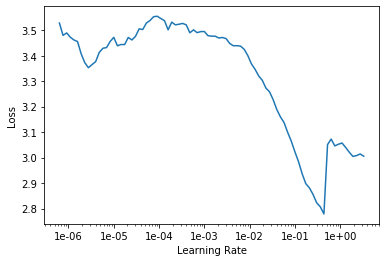

In [3]:
    model = EmbeddingNNModel(review_data,40,40,"model_2")
    train,test = model.split_data()
    
    " Model 2 -  EmbeddingNN Model"

    " Training the model ,creating a collab_learner object."
    learn_obj = model.model_training(train,seed)
   
    
    " Predicting the results on the test data."
    preds,y = model.predict(test)
    
    dict1 ={}
    count = 0
    for index, row in test.iterrows():
        if row["user_id"] == "ELcQDlf69kb-ihJfxZyL0A":
            dict1[row["business_id"]] = preds[count]
        count += 1
        
    print("\n")
    print("\n")
    print("Recommnded business for user id - ELcQDlf69kb-ihJfxZyL0A")
    count = 0
    for item in sorted(dict1.items(), key=lambda x: x[1] ,reverse =True):
        if count < 7:
            print("Business :"+ item[0] +"   " +"Likely Rating :"+ str(int(round(item[1]))))
            count += 1

    
    "Evaluate the model"
    model.evaluate(preds,y)